
# Vegetation Segmentation with VegAnn

This notebook shows how to apply semantic segmentation with the Unet model tuned on the VegAnn dataset for RGB image segmentation into Vegetation/Background pixel classification.

Madec, S., Irfan, K., Velumani, K. et al. VegAnn, Vegetation Annotation of multi-crop RGB images acquired under diverse conditions for segmentation. Sci Data 10, 302 (2023). https://doi.org/10.1038/s41597-023-02098-y

Author : Simon Madec




# Install libraries
For this demo we will use pytorch and pytorch lignthing framewwork along with the segmenattion_models_pytorch library

In [1]:
!pip install torch
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install segmentation_models_pytorch 
!pip install xgboost==1.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-j8swiicb
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-j8swiicb
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit 2c8758f0a847bba2426e889918abb1a762a25926
  Running command git submodule update --init --recursive -q
  Encountered 31 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and


# Import libraries

In [2]:

import pytorch_lightning as pl
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import matplotlib.pyplot as plt
from typing import Dict, List


# Declare Vegann Model :

In [3]:
class VegAnnModel(pl.LightningModule):
    def __init__(self, arch: str, encoder_name: str, in_channels: int, out_classes: int, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.train_outputs, self.val_outputs, self.test_outputs = [], [], []

    def forward(self, image: torch.Tensor):
        # normalize image here #todo
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch: Dict, stage: str):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs: List[Dict], stage: str):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        dataset_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        dataset_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_per_image_f1": per_image_f1,
            f"{stage}_dataset_f1": dataset_f1,
            f"{stage}_per_image_acc": per_image_acc,
            f"{stage}_dataset_acc": dataset_acc,
        }

        self.log_dict(metrics, prog_bar=True, sync_dist=True, rank_zero_only=True)

    def training_step(self, batch: Dict, batch_idx: int):
        step_outputs = self.shared_step(batch, "train")
        self.train_outputs.append(step_outputs)
        return step_outputs

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.train_outputs, "train")
        self.train_outputs = []

    def validation_step(self, batch: Dict, batch_idx: int):
        step_outputs = self.shared_step(batch, "valid")
        self.val_outputs.append(step_outputs)
        return step_outputs

    def on_validation_epoch_end(self, *args, **kwargs):
        self.shared_epoch_end(self.val_outputs, "valid")
        self.val_outputs = []

    def test_step(self, batch: Dict, batch_idx: int):
        step_outputs = self.shared_step(batch, "test")
        self.test_outputs.append(step_outputs)
        return step_outputs

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_outputs, "test")
        self.test_outputs = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


def colorTransform_VegGround(im,X_true,alpha_vert,alpha_g):
    alpha = alpha_vert
    color = [97,65,38]
    # color = [x / 255 for x in color]
    image=np.copy(im)
    for c in range(3):
        image[:, :, c] =np.where(X_true == 0,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    alpha = alpha_g
    color = [34,139,34]
#    color = [x / 255 for x in color]
    for c in range(3):
        image[:, :, c] =np.where(X_true == 1,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    return image 


# Load Image and Model weights and example image (from google drive)

In [4]:
!gdown https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
ckt_path = "/content/VegAnn.ckpt"
!gdown https://drive.google.com/uc?id=1i9urbc8EUa44BwWmrpOEngFkvFSNIye9
imname = "test2.png"

Downloading...
From: https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
To: /content/VegAnn.ckpt
100% 294M/294M [00:07<00:00, 38.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i9urbc8EUa44BwWmrpOEngFkvFSNIye9
To: /content/test2.png
100% 513k/513k [00:00<00:00, 93.4MB/s]


# Load weights of VegAnn model

In [5]:

checkpoint = torch.load(ckt_path, map_location=torch.device('cpu'))
model = VegAnnModel("Unet","resnet34",in_channels = 3, out_classes=1 )
model.load_state_dict(checkpoint["state_dict"])
preprocess_fn = smp.encoders.get_preprocessing_fn("resnet34", pretrained= "imagenet")
model.eval()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 50.4MB/s]


VegAnnModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

# Predict and Visualize

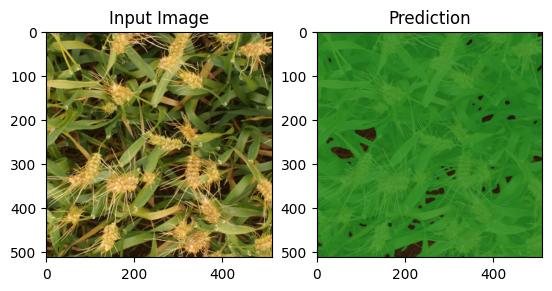

In [6]:
image = cv2.imread(imname)
im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
image = preprocess_input(im)
image = image.astype('float32')


inputs = torch.tensor(image) # , dtype=float
# print(inputs.size)
inputs = inputs.permute(2,0,1)
inputs = inputs[None,:,:,:]
# print(inputs.shape)
logits = model(inputs)
pr_mask = logits.sigmoid()

pred = (pr_mask > 0.5).numpy().astype(np.uint8) 

im1_pred = colorTransform_VegGround(im,pred,0.8,0.2)
im2_pred = colorTransform_VegGround(im,pred,0.2,0.8)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax1.set_title("Input Image")

ax2.imshow(im2_pred)
ax2.set_title("Prediction")
plt.show()



# Senescent Segmentation with SegVeg

This section shows how to apply semantic segmentation with the SVM | XGBoost model tuned on the SegVeg dataset for RGB image segmentation into Green Vegetation/Senescent Vegetation pixel classification.

Serouart Mario Madec Simon David Etienne Velumani Kaaviya Lopez Lozano Raul Weiss Marie Baret Frédéric . SegVeg: Segmenting RGB Images into Green and Senescent Vegetation by Combining Deep and Shallow Methods. Plant Phenomics. 2022;2022:DOI:10.34133/2022/9803570

Authors : Mario Serouart | Simon Madec




In [7]:
import logging
import pathlib
import pandas as pd
import os
import glob
import numpy as np
import PIL
from PIL import Image, ImageCms
import pickle
from tqdm import tqdm
import cv2
from skimage import color, io
import time
#from joblib import Parallel, delayed
import json
from pathlib import Path

def get_features(image) :

    pil_image = Image.fromarray(image)

    hsv = np.array(pil_image.convert(mode='HSV'))
    srgb_p = ImageCms.createProfile("sRGB")
    lab_p  = ImageCms.createProfile("LAB")
    rgb2lab = ImageCms.buildTransformFromOpenProfiles(srgb_p, lab_p, "RGB", "LAB")
    Lab = np.array(ImageCms.applyTransform(pil_image, rgb2lab))
    ycbcr = np.array(pil_image.convert(mode='YCbCr'))
    Labb = color.rgb2lab(image)
    r = image[:, :,0]
    g = image[:, :, 1]
    b = image[:, :, 2]

    h = ((hsv[:,:,0]) * 360) / 255
    s = (hsv[:, :, 1]) / 2.55
    a = Labb[:, :, 1]
    bb = Lab[:, :, 2]
    ge =  np.mean([r,g,b], axis = 0)
    
    CMYlist = [1 - r / 255, 1 - g / 255, 1 - b / 255] 
    CMYlist = np.array([np.min(idx) for idx in zip(*CMYlist)])
    m = ((1 - g / 255 - CMYlist ) / (1 - CMYlist )) * 100
    ye = ((1 - b / 255 - CMYlist ) / (1 - CMYlist )) * 100
    
    cb = ycbcr[:, :, 1]
    cr = ycbcr[:, :, 2]

    i = (0.596 * r - 0.275 * g - 0.321 * b)
    q = (0.212 * r - 0.523 * g + 0.311 * b)
    
    model_input = np.stack((r,g,b,h,s,a,bb,ge,m,ye,cb,cr,i,q), axis=2).squeeze(0)
    model_input = np.nan_to_num(model_input) # Handle black pixels (avoiding Input contains NaN, infinity or a value too large for dtype('float64') error)

    return model_input

    ### Old Parallelise .predict() method ###
    """
    n_cores = config['model_parameters']['n_cores']
    n_samples = X.shape[0]
    slices = [(int(n_samples*i/n_cores), int(n_samples*(i+1)/n_cores)) for i in range(n_cores)]
    data_chunks = [X[i[0]:i[1]] for i in slices]

    if n_cores > 1:
        jobs = (delayed(loaded_model.predict)(array) for array in data_chunks)
        parallel = Parallel(n_jobs=n_cores)

        y_pred  = parallel(jobs)
    else:
        y_pred = [loaded_model.predict(array) for array in data_chunks]

    y_pred  = np.concatenate(y_pred) # Instead of vstack (avoiding all the input array dimensions for the concatenation axis must match exactly error)
    """

def automatic_contrast(image, clip = 0.01):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Cumulative distribution from the histogram
    cumul = []
    cumul.append(float(hist[0]))
    for index in range(1, hist_size):
        cumul.append(cumul[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = cumul[-1]
    clip *= (maximum/100.0)
    clip /= 2.0

    # Left cut
    minimum_gray = 0
    while cumul[minimum_gray] < clip:
        minimum_gray += 1

    # Right cut
    maximum_gray = hist_size -1
    while cumul[maximum_gray] >= (maximum - clip):
        maximum_gray -= 1

    # Alpha and beta values
    alpha = (255 / (maximum_gray - minimum_gray)) + 0.4
    beta = (-minimum_gray * alpha)*2


    # Calculate new histogram with desired range and show histogram 
    contr_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (contr_result, alpha, beta)


def prediction(image, model, threshold, contrasted, mask) :

    # Ff contrasted apply image contrast
    if contrasted == 1 :
        image, _, _ = automatic_contrast(image)
    
    # Revert channels to have RGB /!\ IMPORTANT
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    # If Mask doesn't exist create one full of 1's
    if mask is None:
        mask = np.ones((height, width))

    # Flatten arrays
    image = image.reshape((width*height), 1, 3)
    mask = mask.reshape((width*height), 1)

    # Select indices of vegetation pixels
    yellow_green_mask = np.zeros(image.shape[:-1]) # Null array to set bckg pixels to 0
    vegetation_pixels = mask > 0 # Get vegetation pixels indices
    image = image[None, vegetation_pixels]

    # Apply preprocessing to add features to each pixels
    featured_image = get_features(image)
        
    # Predictions on vegetation pixels
    y_pred = (model.predict_proba(featured_image)[:,1] >= threshold).astype(int)

    # Replace pixels of null array at vegetation indices with output of classification
    yellow_green_mask[vegetation_pixels] = y_pred
    # Reshape
    mask[(mask == 1) & (yellow_green_mask != 1)] = 2
    mask = mask.reshape((height, width))
    # Rotate image
    
    return mask

def visualisation(rgb_image: np.ndarray, yg_mask: np.ndarray) -> np.ndarray:
    
    image_copy = rgb_image.copy()
    image_copy[yg_mask==1] = (0,100,0)
    image_copy[yg_mask==2] = (0,215,255)

    visualisation = cv2.addWeighted(rgb_image,0.25, image_copy, 0.75, 0)

    return visualisation


In [8]:
# load the model_XG + SVM
!gdown https://drive.google.com/uc?id=1EKiXoiUSM2rbidaQFnI8jZucFA3zl22s  
!gdown https://drive.google.com/uc?id=1ApA0ojka3KBzWfvqzhTGNjjWIZnjemNT

model_path = "/content/XGBoost"
model_XG = pickle.load(Path(model_path).open("rb"))

model_path = "/content/model_scikit"
model_SVM = pickle.load(Path(model_path).open("rb"))

new_attrs = ['grow_policy', 'max_bin', 'eval_metric', 'callbacks', 'early_stopping_rounds', 'max_cat_to_onehot', 'max_leaves', 'sampling_method', 'enable_categorical', 'feature_types', 'max_cat_threshold', 'predictor']
for attr in new_attrs:
    setattr(model_XG, attr, None)

Downloading...
From: https://drive.google.com/uc?id=1EKiXoiUSM2rbidaQFnI8jZucFA3zl22s
To: /content/XGBoost
100% 276k/276k [00:00<00:00, 97.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ApA0ojka3KBzWfvqzhTGNjjWIZnjemNT
To: /content/model_scikit
100% 65.0k/65.0k [00:00<00:00, 75.3MB/s]


/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Downloading...
From: https://drive.google.com/uc?id=1i9urbc8EUa44BwWmrpOEngFkvFSNIye9
To: /content/test2.png
100% 513k/513k [00:00<00:00, 145MB/s]
### XGBoost Model ###


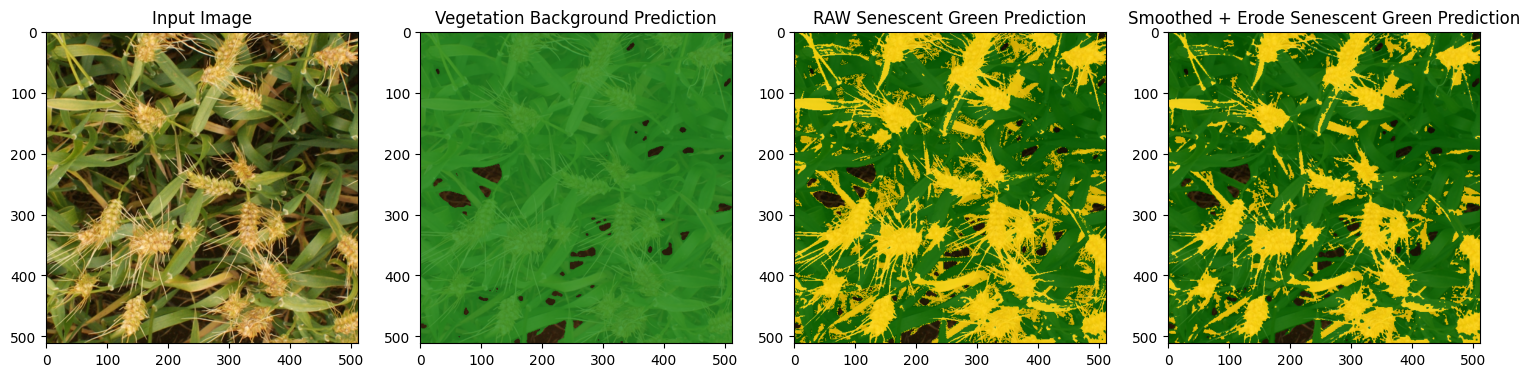

Downloading...
From: https://drive.google.com/uc?id=1nxUmWQAqWbKANRJbNwRh8b58p0amkcix
To: /content/LiteralDataset_2.png
100% 579k/579k [00:00<00:00, 140MB/s]
### SVM Model ###


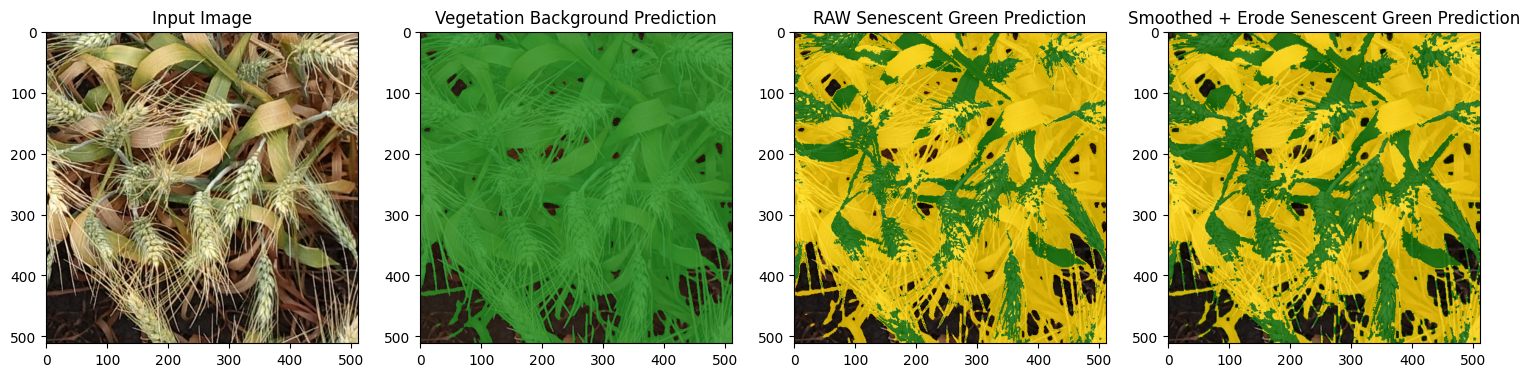

In [11]:
import xgboost

!gdown https://drive.google.com/uc?id=1i9urbc8EUa44BwWmrpOEngFkvFSNIye9
imname = "test2.png"

image = cv2.imread(imname)
im_XG = cv2.imread(imname)
im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
image = preprocess_input(im)
image = image.astype('float32')

inputs = torch.tensor(image) # , dtype=float
# print(inputs.size)
inputs = inputs.permute(2,0,1)
inputs = inputs[None,:,:,:]
# print(inputs.shape)
logits = model(inputs)
pr_mask = logits.sigmoid()

pred = (pr_mask > 0.5).numpy().astype(np.uint8) 


im1_pred = colorTransform_VegGround(im,pred,0.8,0.2)
im2_pred = colorTransform_VegGround(im,pred,0.2,0.8)

raw_yellow_green_mask = prediction(im_XG, model_XG, mask=pred, threshold=0.5, contrasted=1)
raw_visu = visualisation(im_XG, raw_yellow_green_mask)
raw_visu = cv2.cvtColor(raw_visu, cv2.COLOR_BGR2RGB)

yellow_green_mask = cv2.erode(raw_yellow_green_mask, np.ones((2,2), np.uint8), iterations=1)
yellow_green_mask = cv2.GaussianBlur(yellow_green_mask, (3,3), 0)
visu = visualisation(im_XG, yellow_green_mask)
visu = cv2.cvtColor(visu, cv2.COLOR_BGR2RGB)

print("### XGBoost Model ###")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(im)
ax1.set_title("Input Image")

ax2.imshow(im2_pred)
ax2.set_title("Vegetation Background Prediction")

ax3.imshow(raw_visu)
ax3.set_title("RAW Senescent Green Prediction")

ax4.imshow(visu)
ax4.set_title("Smoothed + Erode Senescent Green Prediction")
plt.show()

###
###

!gdown https://drive.google.com/uc?id=1nxUmWQAqWbKANRJbNwRh8b58p0amkcix
imname = "LiteralDataset_2.png"

image = cv2.imread(imname)
im_XG = cv2.imread(imname)
im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
image = preprocess_input(im)
image = image.astype('float32')

inputs = torch.tensor(image) # , dtype=float
# print(inputs.size)
inputs = inputs.permute(2,0,1)
inputs = inputs[None,:,:,:]
# print(inputs.shape)
logits = model(inputs)
pr_mask = logits.sigmoid()

pred = (pr_mask > 0.5).numpy().astype(np.uint8) 

im1_pred = colorTransform_VegGround(im,pred,0.8,0.2)
im2_pred = colorTransform_VegGround(im,pred,0.2,0.8)

raw_yellow_green_mask = prediction(im_XG, model_SVM, mask=pred, threshold=0.5, contrasted=0)
raw_visu = visualisation(im_XG, raw_yellow_green_mask)
raw_visu = cv2.cvtColor(raw_visu, cv2.COLOR_BGR2RGB)

yellow_green_mask = cv2.erode(raw_yellow_green_mask, np.ones((2,2), np.uint8), iterations=1)
yellow_green_mask = cv2.GaussianBlur(yellow_green_mask, (3,3), 0)
visu = visualisation(im_XG, yellow_green_mask)
visu = cv2.cvtColor(visu, cv2.COLOR_BGR2RGB)

print("### SVM Model ###")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(im)
ax1.set_title("Input Image")

ax2.imshow(im2_pred)
ax2.set_title("Vegetation Background Prediction")

ax3.imshow(raw_visu)
ax3.set_title("RAW Senescent Green Prediction")

ax4.imshow(visu)
ax4.set_title("Smoothed + Erode Senescent Green Prediction")
plt.show()
